In [1]:
import glob
import json
import numpy as np
import target_defs
import importlib
importlib.reload(target_defs)
from target_defs import archetype_predictions


# archetype_predictions = {'liquid': np.array([18.177, 2.932]),
#                      'membrane': np.array([1.132, 8.499]),
#                      'spherical micelle': np.array([2.901, -4.351]),
#                      'string': np.array([-4.079, 6.662]),
#                      'vesicle': np.array([6.498, 8.414]),
#                      'wormlike micelle': np.array([-3.771, 0.172]),
#                      }

check_batch_size = lambda buffer: "five" in buffer['params']['initial_prompt']


def criteria(buffer, morph):
    if "five" not in buffer['params']['initial_prompt']:
        return False
    # if "Hint" not in buffer['params']['batch_prompt'] and "Hint" not in buffer['params']['initial_prompt']:
    #     return False
    if "Hint" not in buffer['params']['initial_prompt']:
        return False
    # if "Kremer" in buffer['params']['initial_prompt']:
    #     return False
    if not np.allclose(buffer['params']['target'], archetype_predictions[morph]):
        return False
    if buffer['params']['llm_model'] != "claude-3-opus-20240229":
        return False
    # if "The process will continue" not in buffer['params']['initial_prompt']:
    #     return False
    # if "distances less than 1.0" not in buffer['params']['batch_prompt']:
    #     return False
    if len(buffer['messages']) != 19:
        return False
    # if "temperature" not in buffer['params'] or buffer['params']['temperature'] != 0.1:
    #     return False
    if "temperature" in buffer['params'] and buffer['params']['temperature'] != 0:
        return False
    if "prompt_yml" not in buffer['params'] or buffer['params']['prompt_yml'] != "prompt-oracle-v3.yml":
        return False    
    if "gen_random" not in buffer["params"] or buffer["params"]["gen_random"] is not True:
        return False
    return True

# morph = 'liquid'
# morph = 'membrane'
# morph = 'spherical micelle'
# morph = 'string'
# morph = 'vesicle'
morph = 'wormlike micelle'

# morph = 'arch_g'
# morph = 'km_a'

def find_logs(morph):
    meets_criteria = []
    
    logfiles = sorted(glob.glob('logs/claude-test-*.json'))
    for log in logfiles:
        with open(log, 'r') as fid:
            buffer = json.load(fid)
        if criteria(buffer, morph):
            meets_criteria.append(log)
    
    meets_criteria = meets_criteria[-5:]
    
    return meets_criteria
    
meets_criteria = find_logs(morph)    
print(meets_criteria)

TypeError: list indices must be integers or slices, not str

In [2]:
import message_utils
import importlib
importlib.reload(message_utils)

<module 'message_utils' from '/Users/wfr5091/Code/macro-llm/message_utils.py'>

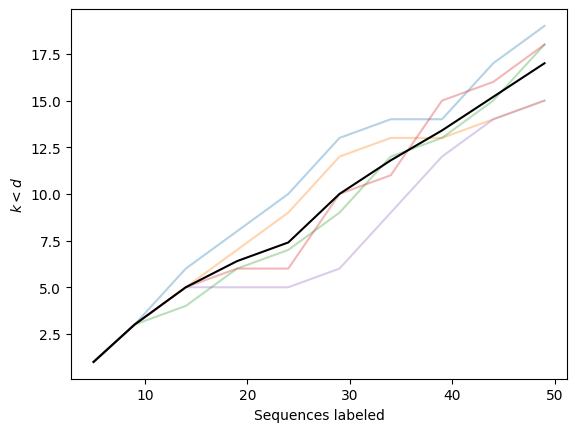

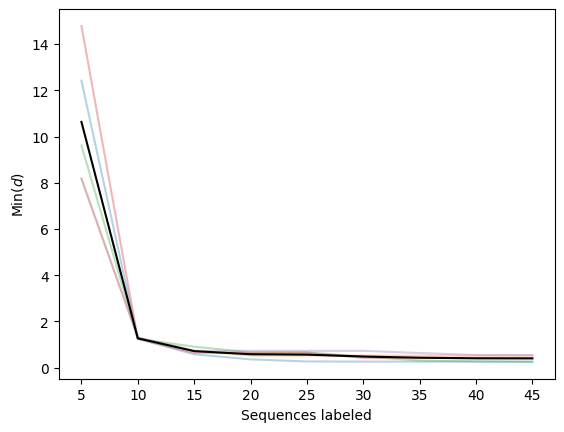

In [4]:
import message_utils
import matplotlib.pyplot as plt


def process_logs_min_d(meets_criteria, min_k=0, top_k=None, plot_iter=False):
    
    rollouts = []
    for logfile in meets_criteria:
        with open(logfile, 'r') as fid:
            buffer = json.load(fid)
        messages = buffer['messages']
        rollouts.append(messages)
    
    results = []
    n = 0
    for fake_payload in rollouts:
        iteration_scores = message_utils.extract_results_from_messages(fake_payload)
        if len(iteration_scores[0]) == 0:
            iteration_scores = iteration_scores[1:]
        scs = message_utils.sorted_cumulative_scores(iteration_scores)
        scs_f = [[it for it in x if float(it) > 0] for x in scs]
        min_d = [np.min(it[min_k:]) for it in scs_f]
        if top_k is not None:
            min_d = [np.mean(it[:top_k]) for it in scs_f]
        results.append(min_d)
        if len(scs) > n:
            n = len(scs)
    
    counts_arr = np.zeros((len(rollouts), n)) * np.nan
    for j, fake_payload in enumerate(rollouts):    
        user_messages = [it for it in fake_payload if it['role'] == 'user']
        seq_by_iter = [message_utils.extract_seq_from_user_message(it).strip().split('\n') for it in user_messages[1:]]
        seq_seen = []
        for i, s in enumerate(seq_by_iter):
            seq_seen += s
            seq_seen = sorted(set(seq_seen))
            counts_arr[j, i] = len(seq_seen)
       
    if plot_iter:
        counts_arr = np.vstack([np.arange(1, n+1)]*len(rollouts))   
        
    results_arr = np.zeros((len(rollouts), n)) * np.nan
    for i, r in enumerate(results):
        results_arr[i, :len(r)] = r
    
    for i, r in enumerate(results_arr):
        plt.plot(counts_arr[i], r, alpha=0.33)
    if plot_iter:
        plt.xlabel('Iteration')
    else:
        plt.xlabel('Sequences labeled')
    plt.ylabel('Min($d$)')
    
    nc = int(np.nanmax(counts_arr))
    results_resampled = np.zeros((len(rollouts), nc)) * np.nan
    for i, r in enumerate(results_arr):
        for j in range(nc):
            results_resampled[i, j] = np.interp(j+1, counts_arr[i], r,
                                                left=np.nan, right=np.nan)
    
    plt.plot(np.arange(nc)+1, np.mean(results_resampled, axis=0), 'k-')

    if plot_iter:
        return results_arr
    else:
        return results_resampled


def process_logs_k_lt_d(meets_criteria, plot_iter=False):
    
    rollouts = []
    for logfile in meets_criteria:
        with open(logfile, 'r') as fid:
            buffer = json.load(fid)
        messages = buffer['messages']
        rollouts.append(messages)
    
    results = []
    counts = []
    n = 0
    for fake_payload in rollouts:    
        iteration_scores = message_utils.extract_results_from_messages(fake_payload)
        if len(iteration_scores[0]) == 0:
            iteration_scores = iteration_scores[1:]
        scs = message_utils.sorted_cumulative_scores(iteration_scores)
        kbd = message_utils.k_below_d(scs, 0.67*2)
        results.append(kbd)
        if len(scs) > n:
            n = len(scs)
    
    counts_arr = np.zeros((len(rollouts), n)) * np.nan
    for j, fake_payload in enumerate(rollouts):    
        # user_messages = [it for it in fake_payload if it['role'] == 'user']
        # seq_by_iter = [message_utils.extract_seq_from_user_message(it).strip().split('\n') for it in user_messages[1:]]
        # seq_seen = []
        # for i, s in enumerate(seq_by_iter):
        #     seq_seen += s
        #     seq_seen = sorted(set(seq_seen))
        #     counts_arr[j, i] = len(seq_seen)
        iteration_scores = message_utils.extract_results_from_messages(fake_payload)
        if len(iteration_scores[0]) == 0:
            iteration_scores = iteration_scores[1:]
        k = 0
        for i, s in enumerate(iteration_scores):
            k += len(s)
            counts_arr[j, i] = k
       
    if plot_iter:
        counts_arr = np.vstack([np.arange(1, n+1)]*len(rollouts))   
        
    results_arr = np.zeros((len(rollouts), n)) * np.nan
    for i, r in enumerate(results):
        results_arr[i, :len(r)] = r
    
    for i, r in enumerate(results_arr):
        plt.plot(counts_arr[i], r, alpha=0.33)
    if plot_iter:
        plt.xlabel('Iteration')
    else:
        plt.xlabel('Sequences labeled')
    plt.ylabel('$k < d$')

    nc = int(np.nanmax(counts_arr))
    results_resampled = np.zeros((len(rollouts), nc)) * np.nan
    for i, r in enumerate(results_arr):
        for j in range(nc):
            results_resampled[i, j] = np.interp(j+1, counts_arr[i], r,
                                                left=np.nan, right=np.nan)
    
    plt.plot(np.arange(nc)+1, np.mean(results_resampled, axis=0), 'k-')

    if plot_iter:
        return results_arr
    else:
        return results_resampled

plt.figure()
results_arr = process_logs_k_lt_d(meets_criteria, plot_iter=False)

plt.figure()
results_arr = process_logs_min_d(meets_criteria, top_k=3, plot_iter=False)

In [110]:
results_arr

array([[        nan,         nan,         nan,         nan, 13.859     ,
        12.50477778, 11.15055556,  9.79633333,  8.8015    ,  7.80666667,
         5.23566667,  4.40188889,  3.56811111,  2.73433333,  2.73433333,
         2.48033333,  2.22633333,  2.12916667,  2.032     ,  2.032     ,
         2.032     ,  1.99266667,  1.95333333,  1.95333333,  1.822     ,
         1.69066667,  1.55933333,  1.28511111,  1.01088889,  0.73666667,
         0.73666667,  0.73666667,  0.73666667,  0.73666667,  0.73666667,
         0.73666667,  0.73666667,  0.73666667,  0.73666667,  0.73316667,
         0.72966667,  0.72966667,  0.48633333,  0.48633333,  0.48633333,
         0.48633333,  0.48633333,  0.48633333,  0.48633333,  0.48633333,
         0.48633333,  0.48633333,  0.48633333,  0.48633333,  0.48633333,
         0.48633333],
       [        nan,         nan,         nan,         nan, 14.475     ,
        10.90666667,  6.59966667,  6.20733333,  5.815     ,  3.73266667,
         2.30633333,  1.22333

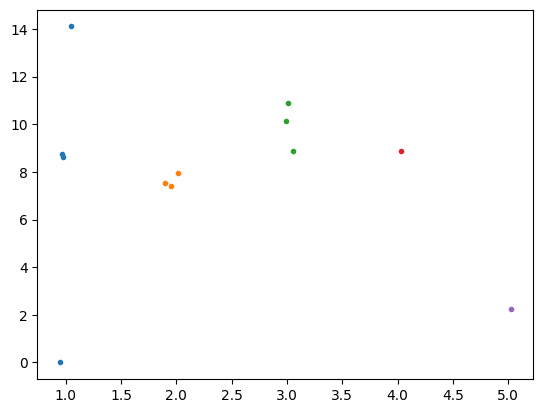

In [5]:
rollouts = []
for logfile in meets_criteria:
    with open(logfile, 'r') as fid:
        buffer = json.load(fid)
    messages = buffer['messages']
    rollouts.append(messages)
    
    try:
        message_utils.plot_results_from_messages(messages)
    except:
        break

In [1042]:
messages[0]

{'role': 'user',
 'content': [{'type': 'text',
   'text': "The objective is to find a sequence of 20 characters, comprising 12 'A' characters and 8 'B' characters, that minimizes the distance from a desired result. I have an oracle that takes in a sequence of 20 characters and produces a numerical distance from the desired result. The smaller the distance, the closer the sequence is to the desired result. Please propose five sequences of 20 characters in the format 'ABBA...', where each sequence contains exactly 12 'A' characters and 8 'B' characters. Based on the distances returned by the oracle for these sequences, propose the next batch of sequences with the goal of minimizing the distance. When proposing the next batch, you should explore sequences that are similar to the ones with the smallest distances from the previous batch, while also maintaining a certain level of diversity to avoid getting stuck in a local minimum. Provide the sequences in a comma-separated list, without any

In [6]:
def extract_seq_from_init_message(message):
    return message['content'][0]['text'].split('started:\n', 1)[1]

extract_seq_from_init_message(messages[0])

'BBAAABBBAAAABBBAAAAA: 0.000\nAAABBBBAAABAAAAABABB: 8.633\nAAABBBBABAAAABAABAAB: 8.762\nBBAABABAABAAAAAAABBB: 14.101\nAABAAAABBBBAAABABABA: 14.180'

(0.0, 14.80605)

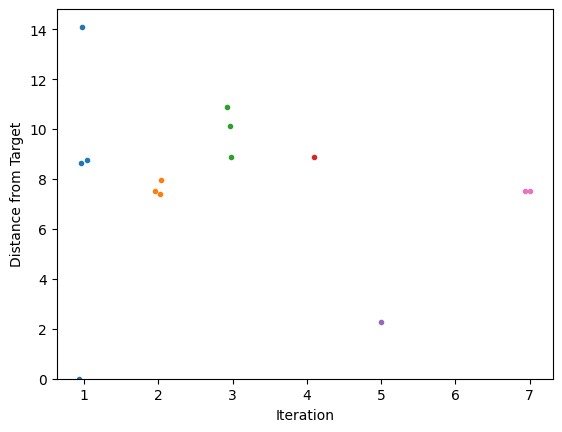

In [7]:
iteration_scores = message_utils.extract_results_from_messages(messages)
fig, ax = plt.subplots()
top_range = 0
for i, it in enumerate(message_utils.extract_results_from_messages(messages)):
    ax.plot(np.ones(len(it))*(i+1)+np.random.randn(len(it))*0.05, it, '.')
    if len(it) > 0:
        top_range = max(top_range, max(it))
ax.set_xlabel('Iteration')
ax.set_ylabel('Distance from Target')
ax.set_ylim(0, top_range*1.05)

In [405]:
def criteria(buffer, morph, use_oracle=False, use_seed=False):
    if "five" not in buffer['params']['initial_prompt']:
        return False
    # if "Hint" not in buffer['params']['batch_prompt'] and "Hint" not in buffer['params']['initial_prompt']:
    #     return False
    if use_seed:
        if "Hint" not in buffer['params']['initial_prompt']:
            return False
    else:
        if "Hint" in buffer['params']['initial_prompt']:
            return False
    if use_oracle:
        if "prompt_yml" not in buffer['params'] or buffer['params']['prompt_yml'] != "prompt-oracle-v3.yml":
            return False 
    else:
        if "prompt_yml" not in buffer['params'] or buffer['params']['prompt_yml'] != "prompt-scientific-v3.yml":
            return False
        # if "Kremer" not in buffer['params']['initial_prompt']:
        #     return False
    if not np.allclose(buffer['params']['target'], archetype_predictions[morph]):
        return False
    if buffer['params']['llm_model'] != "claude-3-opus-20240229":
        return False
    # if "ignore this" not in buffer['params']['initial_prompt']:
    #     return False
    if len(buffer['messages']) != 19:
        return False
    # if "temperature" not in buffer['params'] or buffer['params']['temperature'] != 0.1:
    #     return False    
    if "temperature" in buffer['params'] and buffer['params']['temperature'] != 0:
        return False
    if "gen_random" not in buffer["params"] or buffer["params"]["gen_random"] is not True:
        return False    
    return True


In [9]:
is_five = lambda buffer: "five" in buffer['params']['initial_prompt'] 
is_seeded = lambda buffer: "Hint" in buffer['params']['initial_prompt']
is_oracle = lambda buffer: "prompt_yml" in buffer['params'] and buffer['params']['prompt_yml'] == "prompt-oracle-v4.3d.yml"
is_scientific = lambda buffer: "prompt_yml" in buffer['params'] and buffer['params']['prompt_yml'] == "prompt-scientific-v4.3d.yml"
is_target = lambda buffer: np.allclose(buffer['params']['target'], archetype_predictions[morph])
is_opus = lambda buffer: buffer['params']['llm_model'] == "claude-3-opus-20240229"
is_len_19 = lambda buffer: len(buffer['messages']) >= 19
is_zero_temp = lambda buffer: "temperature" in buffer['params'] and buffer['params']['temperature'] == 0
is_random = lambda buffer: "gen_random" in buffer["params"] and buffer["params"]["gen_random"] is True
is_in_date = lambda logfile: '1712' in logfile
# is_in_date = lambda logfile: '1712' not in logfile


def criteria(buffer, logfile, morph, use_oracle=False, use_seed=False):
    conditions = []
    
    if use_seed:
        conditions.append(is_seeded(buffer))
    else:
        conditions.append(not is_seeded(buffer))
    if use_oracle:
        conditions.append(is_oracle(buffer))
    else:
        conditions.append(is_scientific(buffer))
    conditions.append(is_target(buffer))
    conditions.append(is_opus(buffer))
    conditions.append(is_len_19(buffer))
    conditions.append(is_zero_temp(buffer))
    conditions.append(is_random(buffer))
    conditions.append(is_in_date(logfile))
    
    return all(conditions)


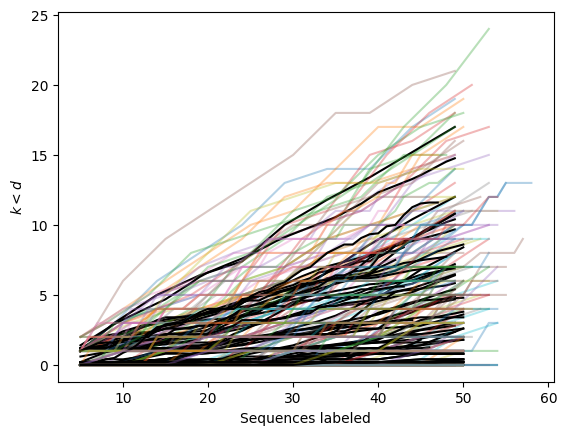

In [35]:
import os

def criteria_active(buffer, morph, use_seed=False):
    if use_seed:
        if 'use_seed' not in buffer['params'] or buffer['params']['use_seed'] == False:
            return False
    else:
        if 'use_seed' not in buffer['params'] or buffer['params']['use_seed'] == True:
            return False
    if not np.allclose(buffer['params']['target'], archetype_predictions[morph]):
        return False
    return True


def criteria_deap(buffer, morph, use_seed=False):
    if use_seed:
        if 'use_seed' not in buffer['params'] or buffer['params']['use_seed'] == False:
            return False
    else:
        if 'use_seed' not in buffer['params'] or buffer['params']['use_seed'] == True:
            return False
    if not np.allclose(buffer['params']['target'], archetype_predictions[morph]):
        return False
    if 'delta' not in buffer['params'] or buffer['params']['delta'] != 0:
        return False
    return True

deap_is_seeded = lambda buffer: 'use_seed' in buffer['params'] and buffer['params']['use_seed']
has_delta = lambda buffer: 'delta' in buffer['params'] and buffer['params']['delta'] == 0

def criteria_deap_v2(buffer, logfile, morph, use_seed=False):
    conditions = []
    
    if use_seed:
        conditions.append(deap_is_seeded(buffer))
    else:
        conditions.append(not deap_is_seeded(buffer))
    conditions.append(is_target(buffer))
    conditions.append(is_in_date(logfile))
    conditions.append(has_delta(buffer))
    
    return all(conditions)


def find_logs_active(morph, use_seed):
    meets_criteria = []
    
    logfiles = sorted(glob.glob('logs/active-learning-*.json'), key=os.path.getmtime)
    for log in logfiles:
        with open(log, 'r') as fid:
            buffer = json.load(fid)
        if 'params' not in buffer:
            continue
        if criteria_active(buffer, morph, use_seed):
            meets_criteria.append(log)
    
    has_hash = [it for it in meets_criteria if it.count('-') == 3]
    if len(has_hash) >= 5:
        meets_criteria = has_hash
    meets_criteria = meets_criteria[-5:]
    
    return meets_criteria


def find_logs_deap(morph, use_seed):
    meets_criteria = []
    
    logfiles = sorted(glob.glob('logs/deap-*.json'), key=os.path.getmtime)
    for log in logfiles:
        try:
            with open(log, 'r') as fid:
                buffer = json.load(fid)
        except json.JSONDecodeError:
            print(f'File broken: {log}')
            continue
        if 'params' not in buffer:
            continue
        if criteria_deap_v2(buffer, log, morph, use_seed):
            meets_criteria.append(log)
    
    has_hash = [it for it in meets_criteria if it.count('-') == 3]
    if len(has_hash) >= 5:
        meets_criteria = has_hash
    meets_criteria = meets_criteria[-5:]
    
    return meets_criteria


def criteria_random(buffer, morph):
    if not np.allclose(buffer['params']['target'], archetype_predictions[morph]):
        return False
    return True


def find_logs_random(morph):
    meets_criteria = []
    
    logfiles = sorted(glob.glob('logs/random-*.json'), key=os.path.getmtime)
    for log in logfiles:
        with open(log, 'r') as fid:
            buffer = json.load(fid)
        if 'params' not in buffer:
            continue
        if criteria_random(buffer, morph):
            meets_criteria.append(log)
    
    has_hash = [it for it in meets_criteria if it.count('-') == 3]
    if len(has_hash) >= 5:
        meets_criteria = has_hash
    meets_criteria = meets_criteria[-5:]
    
    return meets_criteria


def find_logs(morph, use_oracle, use_seed):
    meets_criteria = []
    
    logfiles = sorted(glob.glob('logs/claude-test-*.json'), key=os.path.getmtime)
    for log in logfiles:
        with open(log, 'r') as fid:
            buffer = json.load(fid)
        if 'params' not in buffer:
            continue
        if criteria(buffer, log, morph, use_oracle, use_seed):
            meets_criteria.append(log)
    
    has_hash = [it for it in meets_criteria if it.count('-') == 3]
    if len(has_hash) >= 5:
        meets_criteria = has_hash
    meets_criteria = meets_criteria[-5:]
    
    return meets_criteria

experiment_results = {}
# arch_morphs = [k for k in archetype_predictions.keys() if 'arch_' in k]
# arch_morphs = [k for k in archetype_predictions.keys() if '_' not in k]
# arch_morphs = ['liquid', 'vesicle', 'membrane', 'string', 'wormlike micelle', 'spherical micelle']
arch_morphs = ['liquid', 'string', 'membrane', 'vesicle', 'wormlike micelle', 'spherical micelle']
# arch_morphs = ['string', 'membrane', 'vesicle', 'wormlike micelle', 'spherical micelle']
# arch_morphs = ['wormlike micelle']
# arch_morphs += ['wormlike_v2']
n_min = 50
for experiment in ['oracle', 'scientific', 'active', 'evolutionary', 'random']:
# for experiment in ['oracle', 'scientific', 'active', 'random']:
# for experiment in ['oracle', 'active']:
# for experiment in ['scientific']:
    for seed_type in [True, False]:
        arch_results = []
        for morph in arch_morphs:
            if experiment == 'active':
                meets_criteria = find_logs_active(morph, seed_type)
            elif experiment == 'evolutionary':
                meets_criteria = find_logs_deap(morph, seed_type)
            elif experiment == 'random':
                meets_criteria = find_logs_random(morph)
            else:
                use_oracle = (experiment == 'oracle')
                meets_criteria = find_logs(morph, use_oracle, seed_type)
            # check that all are from the same batch
            batch = [it.strip('.json').split('-')[-1][:-1] for it in meets_criteria]
            if not all([b == batch[0] for b in batch]) and experiment != 'random':
                # raise ValueError(f'Expected all entries from the same batch: {meets_criteria}')
                print(f'Expected all entries from the same batch ({experiment}, {morph}, {seed_type}): {meets_criteria}')
                # continue
            if len(meets_criteria) < 5:
                # raise ValueError(f'Expected 5 entries: {meets_criteria}')
                print(f'Expected 5 entries for ({experiment}, {morph}, {seed_type}): {meets_criteria}')
                continue
            results_arr = process_logs_k_lt_d(meets_criteria, plot_iter=False)
            if results_arr.shape[1] > 50:  # no more than 50 labeled sequences
                results_arr = results_arr[:, :50]
            # results_arr = process_logs_min_d(meets_criteria, top_k=5, plot_iter=True)
            # n_all = np.sum(np.logical_not(np.isnan(results_arr.sum(axis=0)))) + 4
            # if n_all < n_min:
            #     raise ValueError(f'Expected {n_min}+ entries, got {n_all}: {meets_criteria}')
                # print(f'Expected {n_min}+ entries, got {n_all}: {meets_criteria}')
                # continue
            # results_arr = process_logs_min_d(meets_criteria, top_k=3, plot_iter=True)
            # arch_results.append(results_arr[:, (n_min-1)])
            # arch_results.append(results_arr[:, 9])
            n_each = np.array([np.argwhere(np.logical_not(np.isnan(it))).flatten().max() for it in results_arr])
            k_per_n = np.nanmax(results_arr, axis=1) # / n_each
            k_per_n -= int(seed_type and experiment != 'random')
            # if np.min(n_each) < n_min:
            #     print(f'Some runs < {n_min} for ({experiment}, {morph}, {seed_type})')
            #     print(n_each)
            #     break
            arch_results.append(k_per_n.flatten())
        experiment_results[(experiment, seed_type)] = arch_results

## some checks

In [ ]:
print(experiment, seed_type, morph)
print(meets_criteria)
batch = [it.strip('.json').split('-')[-1][:-1] for it in meets_criteria]
print(all([b == batch[0] for b in batch]))

In [25]:
meets_criteria = []

logfiles = sorted(glob.glob('logs/claude-test-*.json'))
for log in logfiles:
    with open(log, 'r') as fid:
        buffer = json.load(fid)
    if criteria(buffer, morph, use_oracle=True, use_seed=True):
        meets_criteria.append(log)

In [105]:
log = 'logs/claude-test-142b787c-17123497722.json'
with open(log, 'r') as fid:
    buffer = json.load(fid)


In [36]:
is_five = lambda buffer: "five" in buffer['params']['initial_prompt'] 
is_seeded = lambda buffer: "Hint" in buffer['params']['initial_prompt']
is_oracle = lambda buffer: "prompt_yml" in buffer['params'] and buffer['params']['prompt_yml'] == "prompt-oracle-v3.yml"
is_scientific = lambda buffer: "prompt_yml" in buffer['params'] and buffer['params']['prompt_yml'] == "prompt-scientific-v3.yml"
is_target = lambda buffer: np.allclose(buffer['params']['target'], archetype_predictions[morph])
is_opus = lambda buffer: buffer['params']['llm_model'] == "claude-3-opus-20240229"
is_len_19 = lambda buffer: len(buffer['messages']) >= 19
is_zero_temp = lambda buffer: "temperature" in buffer['params'] and buffer['params']['temperature'] == 0
is_random = lambda buffer: "gen_random" in buffer["params"] and buffer["params"]["gen_random"] is True

conditions = []

if seed_type:
    conditions.append(is_seeded(buffer))
else:
    conditions.append(not is_seeded(buffer))
if experiment == 'oracle':
    conditions.append(is_oracle(buffer))
else:
    conditions.append(not is_oracle(buffer))
conditions.append(is_target(buffer))
conditions.append(is_opus(buffer))
conditions.append(is_len_19(buffer))
conditions.append(is_zero_temp(buffer))
conditions.append(is_random(buffer))

print(conditions)

NameError: name 'buffer' is not defined

## main plots

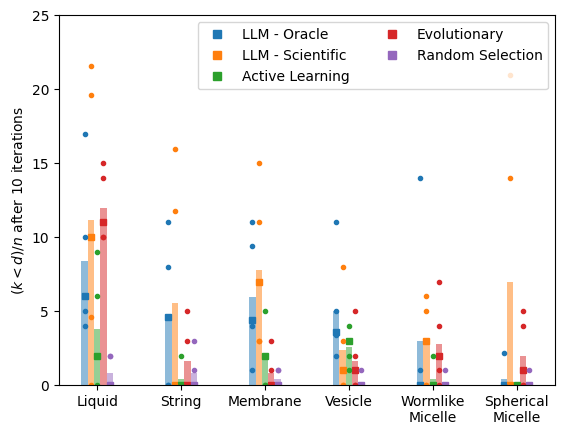

In [38]:
offs = {'oracle': -0.15, 'scientific': -0.075, 'active': +0.0, 'evolutionary': +0.075, 'random': +0.15}
# offs = {'oracle': -0.15, 'scientific': -0.05, 'active': +0.05, 'evolutionary': +0.075, 'random': +0.15}
colors = {'oracle': 'tab:blue', 'scientific': 'tab:orange', 'active': 'tab:green', 'evolutionary': 'tab:red', 'random': 'tab:purple'}
labels = {'oracle': 'LLM - Oracle', 'scientific': 'LLM - Scientific', 'active': 'Active Learning', 'evolutionary': 'Evolutionary', 'random': 'Random Selection'}
for k, v in experiment_results.items():
    experiment, seed_type = k
    # if experiment == 'evolutionary':
    #     continue
    if not (seed_type is False):
        continue
    c = colors[experiment]
    plt.bar(np.arange(len(v))+1+offs[experiment], np.mean(v, axis=1), width=0.075, zorder=0, alpha=0.5)
    # plt.boxplot(v, widths=0.10,
    #             positions=np.arange(len(v))+1+offs[experiment],
    #             notch=False,
    #             patch_artist=True,
    #             boxprops=dict(facecolor=c, color=c, alpha=1.0),
    #             capprops=dict(color='k'),
    #             whiskerprops=dict(color='k'),
    #             flierprops=dict(color=c, markeredgecolor=c),
    #             medianprops=dict(color='k'),
    #             )
    for i, val in enumerate(v):
        plt.plot(np.ones(len(val))*(i+1)+offs[experiment], val, color=c, marker='.', ls='none', zorder=2)
    # plt.plot(np.arange(len(v))+1+offs[experiment], np.median(v, axis=1), 's', ms=6, color=c)
    plt.plot(np.arange(len(v))+1+offs[experiment], np.median(v, axis=1), 's', ms=4, color=c, zorder=1)
plt.xticks(np.arange(len(arch_morphs))+1, [it.title().replace(' ', '\n') for it in arch_morphs])

# plt.ylim(1e-2, 1e2)
# plt.yscale('log')
# plt.ylabel('Min Distance')

# plt.ylim(0, 0.5)
plt.ylim(0, 25)
# plt.ylim(0.5, 100)
# plt.yscale('log')
plt.ylabel('$(k < d) / n$ after 10 iterations')
# plt.ylabel('$(k < d)$ after 10 iterations')

for k in offs.keys():
    # if k == 'evolutionary':
    #     continue
    plt.plot(np.nan, np.nan, 's', color=colors[k], label=str(labels[k]))
plt.legend(loc='upper right', ncol=2)

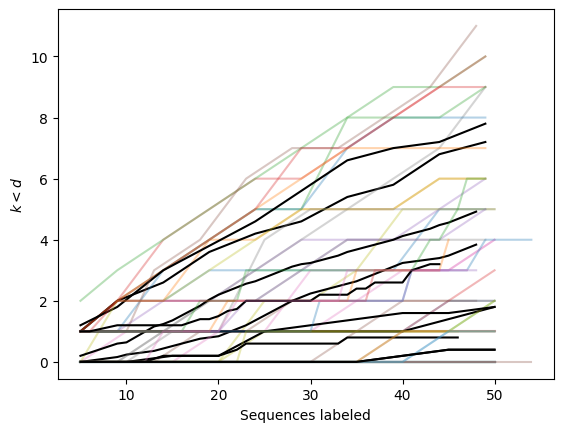

In [47]:
experiment_results = {}
arch_morphs = ['membrane']
for experiment in ['oracle', 'scientific', 'active', 'evolutionary', 'random']:
    for seed_type in [True, False]:
        arch_results = []
        for morph in arch_morphs:
            if experiment == 'active':
                meets_criteria = find_logs_active(morph, seed_type)
            elif experiment == 'evolutionary':
                meets_criteria = find_logs_deap(morph, seed_type)
            elif experiment == 'random':
                meets_criteria = find_logs_random(morph)
            else:
                use_oracle = (experiment == 'oracle')
                meets_criteria = find_logs(morph, use_oracle, seed_type)
            results_arr = process_logs_k_lt_d(meets_criteria, plot_iter=False)
            # results_arr = process_logs_min_d(meets_criteria, min_k=0, plot_iter=True)
            arch_results.append(results_arr[:, :50]-int(seed_type and experiment != 'random'))
        experiment_results[(experiment, seed_type)] = arch_results

(0.0, 52.25)

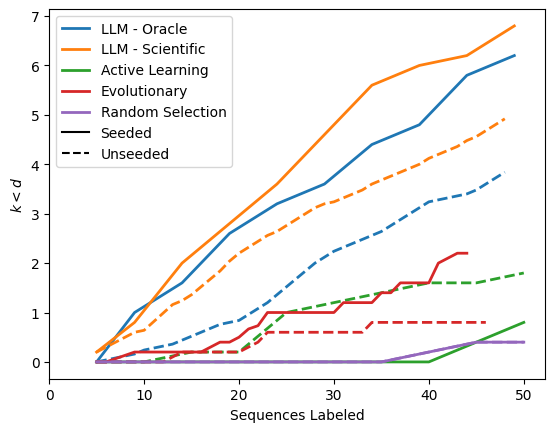

In [48]:
for k, v in experiment_results.items():
    experiment, seed_type = k
    c = colors[experiment]
    if seed_type:
        ls = '-'
        lab = labels[experiment]
    else:
        ls = '--'
        lab = None
    # plt.plot(v[0].T, color=c, alpha=0.33, lw=1.0)
    plt.plot(np.arange(v[0].shape[1])+1, v[0].mean(axis=0), color=c, alpha=1.0, lw=2.0, ls=ls, label=lab)
    # plt.fill_between(np.arange(v[0].shape[1])+1, v[0].min(axis=0), v[0].max(axis=0), alpha=0.20)
plt.plot(np.nan, np.nan, 'k-', label='Seeded')
plt.plot(np.nan, np.nan, 'k--', label='Unseeded')
plt.legend(loc='upper left')
plt.ylabel('$k < d$')
plt.xlabel('Sequences Labeled')
plt.xlim(0)

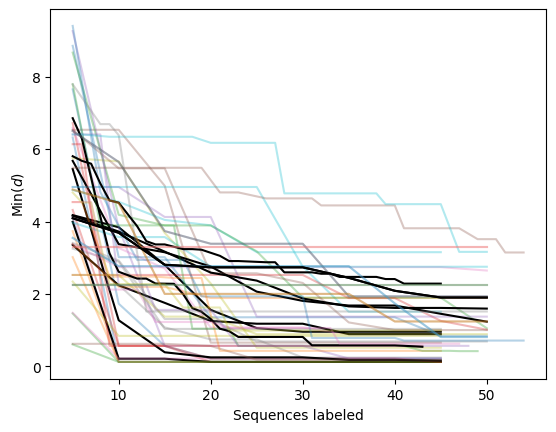

In [43]:
experiment_results = {}
arch_morphs = ['membrane']
for experiment in ['oracle', 'scientific', 'active', 'evolutionary', 'random']:
    for seed_type in [True, False]: # [True, False]:
        arch_results = []
        for morph in arch_morphs:
            if experiment == 'active':
                meets_criteria = find_logs_active(morph, seed_type)
            elif experiment == 'evolutionary':
                meets_criteria = find_logs_deap(morph, seed_type)
            elif experiment == 'random':
                meets_criteria = find_logs_random(morph)
            else:
                use_oracle = (experiment == 'oracle')
                meets_criteria = find_logs(morph, use_oracle, seed_type)
            results_arr = process_logs_min_d(meets_criteria, top_k=1, plot_iter=False)
            arch_results.append(results_arr[:, :50])
        experiment_results[(experiment, seed_type)] = arch_results

Text(0.5, 0, 'Sequences labeled, $n$')

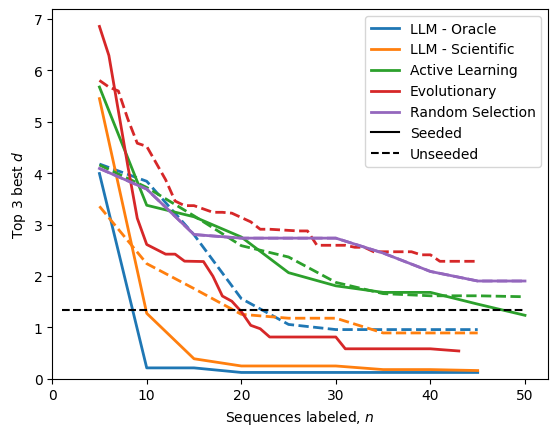

In [45]:
for k, v in experiment_results.items():
    experiment, seed_type = k
    c = colors[experiment]
    if seed_type:
        ls = '-'
        lab = labels[experiment]
    else:
        ls = '--'
        lab = None
    # plt.plot(v[0].T, color=c, alpha=0.33, lw=1.0)
    plt.plot(np.arange(v[0].shape[1])+1, v[0].mean(axis=0), color=c, alpha=1.0, lw=2.0, ls=ls, label=lab)
    # plt.fill_between(np.arange(v[0].shape[1])+1, v[0].min(axis=0), v[0].max(axis=0), alpha=0.20)
plt.plot([1, 50], [1.34, 1.34], 'k--')#, label='Threshold')
plt.plot(np.nan, np.nan, 'k-', label='Seeded')
plt.plot(np.nan, np.nan, 'k--', label='Unseeded')
plt.legend(loc='upper right')
# plt.ylabel(r'$\langle d \rangle_\mathrm{top 3}$')
plt.xlim(0)
plt.ylim(0)
plt.ylabel('Top 3 best $d$')
plt.xlabel('Sequences labeled, $n$')

In [50]:
experiment_results = {}
arch_morphs = ['membrane']
for experiment in ['oracle', 'scientific', 'active', 'evolutionary', 'random']:
    for seed_type in [False]: # [True, False]:
        arch_results = []
        for morph in arch_morphs:
            if experiment == 'active':
                meets_criteria = find_logs_active(morph, seed_type)
            elif experiment == 'random':
                meets_criteria = find_logs_random(morph)
            else:
                use_oracle = (experiment == 'oracle')
                meets_criteria = find_logs(morph, use_oracle, seed_type)
            results_arr = []
            for log in meets_criteria:
                with open(log, 'r') as fid:
                    messages = json.load(fid)['messages']
                iteration_scores = message_utils.extract_results_from_messages(messages)
                iteration_scores = [it if len(it) > 0 else [np.nan] for it in iteration_scores]
                # results_arr.append(message_utils.sorted_cumulative_scores(iteration_scores[:10]))
                results_arr.append(iteration_scores)
            arch_results.append(results_arr)
        experiment_results[(experiment, seed_type)] = arch_results

(0.0, 12.19715)

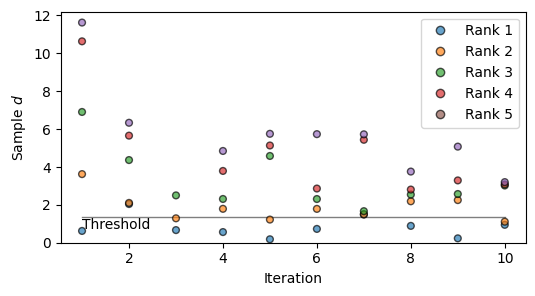

In [56]:
fig, ax = plt.subplots(figsize=(6, 3))
for k, v in experiment_results.items():
    v = v[0]  # only membrane
    experiment, seed_type = k
    if experiment != 'scientific':
        continue
    c = colors[experiment]
    # plt.plot(v[0].T, color=c, alpha=0.33, lw=1.0)
    for j in range(len(v)):
        # plt.plot(np.arange(len(v[j]))+1, [np.nanmin(row) for row in v[j]], '-', color=c)
        for i, row in enumerate(v[j]):
            # plt.plot(np.ones_like(row)*(i+1), row, '.', color=c, alpha=1)
            plt.scatter(np.ones_like(row)*(i+1), row, c=np.argsort(row), s=24, cmap='tab10', vmin=0, vmax=9, alpha=0.67, edgecolors='k')
        break
tabcolors = ['blue', 'orange', 'green', 'red', 'brown']
for i in range(5):
    plt.plot(np.nan, np.nan, 'o', color=f"tab:{tabcolors[i]}", mec='k', label=f"Rank {i+1}", alpha=0.67)
# im = plt.scatter(np.nan*np.ones(2), np.nan*np.ones(2), c=[0, 9], cmap='tab10', vmin=0, vmax=9)
# cb = plt.colorbar(im)
# cb.set_label('')
plt.legend(loc='upper right')
plt.plot([1, 10], [1.34, 1.34], 'k-', lw=1, label='Threshold', zorder=-1, alpha=0.5)
plt.text(1, 1.3, 'Threshold', va='top', ha='left')
plt.ylabel('Sample $d$')
plt.xlabel('Iteration')
plt.ylim(0)

In [1296]:
message_utils.extract_AB_substrings(messages[1]['content'][0]['text'])
# message_utils.extract_seq_from_user_message(messages[1])

['AABABABBBAAABAABAAAB',
 'ABABBAAABBAAABAAAABB',
 'AABBBBAAABABBAAAAAAB',
 'ABABAABBBAABAAAABAAB',
 'AABAABAABABABBABABAA']

In [57]:
import os
import torch

# load the model ensemble
drive_prefix = '/Users/wfr5091/Google Drive/Shared drives/Polymers-Data'

model_ensemble = []
model_path = os.path.join(drive_prefix, 'models', 'gru-opt-cv10-sym')
for i in range(10):
    model = torch.jit.load(os.path.join(model_path, f'fold-{i:02d}-scripted.pt'), map_location='cpu')
    model.eval()
    model_ensemble.append(model)

In [58]:
import alphashape
import numpy as np
import pandas as pd


def make_alpha_hull(xy, alpha=1):
    alpha_shape = alphashape.alphashape(xy, alpha)
    xH, yH = alpha_shape.boundary.coords.xy
    return np.vstack([xH, yH]).T


all_data = []
for keyword in ['random', 'kmeans']:
    data = pd.read_csv(f'polymers-umap-{keyword}.txt', header=None, names=['Sequence', 'Z0', 'Z1'])
    all_data.append(data)

orig_data = pd.concat(all_data)
orig_hull = make_alpha_hull(orig_data.loc[:, 'Z0':'Z1'])

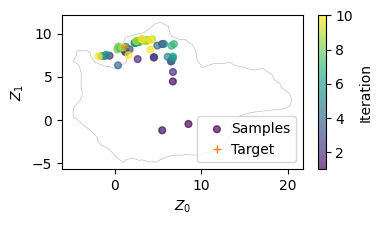

In [65]:
import model_utils


fig, ax = plt.subplots(1, 1, figsize=(4, 2))

morph = 'membrane'
use_oracle = False
seed_type = False
meets_criteria = find_logs(morph, use_oracle, seed_type)
log = meets_criteria[0]
with open(log, 'r') as fid:
    messages = json.load(fid)['messages']

# for LLM
all_iter = np.zeros(0)
all_preds = np.zeros((0, 2))
for i in [0] + list(range(1, 19, 2)):
    sequences = message_utils.extract_AB_substrings(messages[i]['content'][0]['text'])
    sequences = [it for it in sequences if len(it) == 20]
    preds = model_utils.run_sequences(sequences, model_ensemble)
    preds = [it.split(':')[1] for it in preds.split('\n')]
    preds = np.array([np.array([float(it) for it in x.split(',')]) for x in preds])
    all_preds = np.vstack([all_preds, preds])
    this_iter = np.ones(len(preds))*(i//2+1)
    if i == 0:
        this_iter *= 0
    all_iter = np.hstack([all_iter, this_iter])

im = ax.scatter(*all_preds.T, c=all_iter+1, s=24, label='Samples', zorder=1, alpha=0.67)
cb = plt.colorbar(im)
cb.set_label('Iteration')
ax.plot(*archetype_predictions[morph], '+', c='tab:orange', label='Target', zorder=2)
ax.plot(*orig_hull.T, 'k-', lw=0.5, alpha=0.25, zorder=-1)
ax.set_xlabel('$Z_0$')
ax.set_ylabel('$Z_1$')
ax.set_aspect('equal')
ax.legend(loc='lower right', handletextpad=0.0, ncol=1)

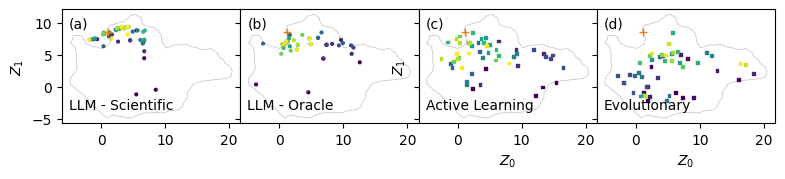

In [69]:
import model_utils


# fig, axes = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(4.6, 3))
fig, axes = plt.subplots(1, 4, sharex='all', sharey='all', figsize=(4.6*2, 3*0.5))
fig.subplots_adjust(hspace=0, wspace=0)

axes = axes.reshape(2, 2)

morph = 'membrane'
seed_type = False

use_oracle = False
meets_criteria = find_logs(morph, use_oracle, seed_type)
log = meets_criteria[0]
with open(log, 'r') as fid:
    messages = json.load(fid)['messages']

ax = axes[0, 0]

# for LLM
all_iter = np.zeros(0)
all_preds = np.zeros((0, 2))
for i in [0] + list(range(1, 19, 2)):
    sequences = message_utils.extract_AB_substrings(messages[i]['content'][0]['text'])
    sequences = [it for it in sequences if len(it) == 20]
    preds = model_utils.run_sequences(sequences, model_ensemble)
    preds = [it.split(':')[1] for it in preds.split('\n')]
    preds = np.array([np.array([float(it) for it in x.split(',')]) for x in preds])
    all_preds = np.vstack([all_preds, preds])
    this_iter = np.ones(len(preds))*(i//2+1)
    if i == 0:
        this_iter *= 0
    all_iter = np.hstack([all_iter, this_iter])

ax.scatter(*all_preds.T, c=all_iter+1, s=4)
ax.plot(*archetype_predictions[morph], '+', color='tab:orange')
# ax.set_xlabel('$Z_0$')
ax.set_ylabel('$Z_1$')
ax.set_aspect('equal')

use_oracle = True
meets_criteria = find_logs(morph, use_oracle, seed_type)
log = meets_criteria[0]
with open(log, 'r') as fid:
    messages = json.load(fid)['messages']

ax = axes[0, 1]

# for LLM
all_iter = np.zeros(0)
all_preds = np.zeros((0, 2))
for i in [0] + list(range(1, 19, 2)):
    sequences = message_utils.extract_AB_substrings(messages[i]['content'][0]['text'])
    sequences = [it for it in sequences if len(it) == 20]
    preds = model_utils.run_sequences(sequences, model_ensemble)
    preds = [it.split(':')[1] for it in preds.split('\n')]
    preds = np.array([np.array([float(it) for it in x.split(',')]) for x in preds])
    all_preds = np.vstack([all_preds, preds])
    this_iter = np.ones(len(preds))*(i//2+1)
    if i == 0:
        this_iter *= 0
    all_iter = np.hstack([all_iter, this_iter])

ax.scatter(*all_preds.T, c=all_iter+1, s=4)
ax.plot(*archetype_predictions[morph], '+', color='tab:orange')
# ax.set_xlabel('$Z_0$')
# ax.set_ylabel('$Z_1$')
ax.set_aspect('equal')

# for active learning
meets_criteria = find_logs_active(morph, seed_type)
log = meets_criteria[0]
with open(log, 'r') as fid:
    messages = json.load(fid)['messages']

ax = axes[1, 0]

# for active learning
all_iter = np.zeros(0)
all_preds = np.zeros((0, 2))
for i in range(1, 11):
    sequences = message_utils.extract_AB_substrings(messages[i]['content'][0]['text'])
    sequences = [it for it in sequences if len(it) == 20]
    preds = model_utils.run_sequences(sequences, model_ensemble)
    preds = [it.split(':')[1] for it in preds.split('\n')]
    preds = np.array([np.array([float(it) for it in x.split(',')]) for x in preds])
    all_preds = np.vstack([all_preds, preds])
    this_iter = np.ones(len(preds))*(i)
    all_iter = np.hstack([all_iter, this_iter])

ax.scatter(*all_preds.T, c=all_iter+1, s=4, marker='s')
ax.plot(*archetype_predictions[morph], '+', color='tab:orange')
ax.set_xlabel('$Z_0$')
ax.set_ylabel('$Z_1$')
ax.set_aspect('equal')

# for random
# meets_criteria = find_logs_random(morph)  # for random
meets_criteria = find_logs_deap(morph, seed_type)  # for evo
log = meets_criteria[0]
with open(log, 'r') as fid:
    messages = json.load(fid)['messages']

ax = axes[1, 1]

# for random
all_iter = np.zeros(0)
all_preds = np.zeros((0, 2))
# for i in range(1, 11):
i = 1
while i == 1 or len(all_preds) < 50:
    sequences = message_utils.extract_AB_substrings(messages[i]['content'][0]['text'])
    sequences = [it for it in sequences if len(it) == 20]
    preds = model_utils.run_sequences(sequences, model_ensemble)
    preds = [it.split(':')[1] for it in preds.split('\n')]
    preds = np.array([np.array([float(it) for it in x.split(',')]) for x in preds])
    all_preds = np.vstack([all_preds, preds])
    this_iter = np.ones(len(preds))*(i)
    all_iter = np.hstack([all_iter, this_iter])
    i += 1
    # print(i, len(all_preds))

ax.scatter(*all_preds.T, c=all_iter+1, s=4, marker='s')
ax.plot(*archetype_predictions[morph], '+', color='tab:orange')
ax.set_xlabel('$Z_0$')
# ax.set_ylabel('$Z_1$')
ax.set_aspect('equal')

abc = 'abcd'
labels = ['LLM - Scientific', 'LLM - Oracle', 'Active Learning', 'Evolutionary']
k = 0
for i in range(2):
    for j in range(2):
        axes[i, j].plot(*orig_hull.T, 'k-', lw=0.5, alpha=0.25)
        axes[i, j].text(-5, 11, f"({abc[k]})", ha='left', va='top', fontsize=10)
        axes[i, j].text(-5, -4, f"{labels[k]}", ha='left', va='bottom', fontsize=10)
        k += 1